# 回归问题
> 回归问题起始就是求输入和输出之间的关系，将这个关系描述成一个函数



In [1]:
%matplotlib inline
import sys
from mxnet import gluon
from d2l import mxnet as d2l

d2l.use_svg_display()

In [2]:
# 读取数据
mnist_train = gluon.data.vision.FashionMNIST(train=True)
mnist_test = gluon.data.vision.FashionMNIST(train=False)

In [16]:
len(mnist_train), len(mnist_test)
print(mnist_train)

In [8]:
mnist_train[0][0].shape

(28, 28, 1)

In [9]:
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [10]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img.asnumpy())
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

(18, 28, 28, 1)


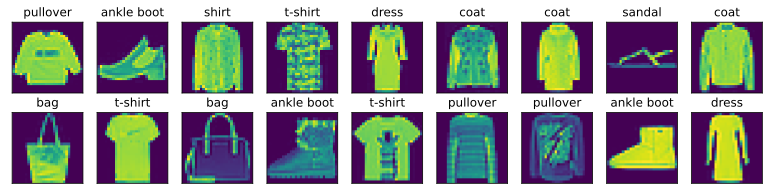

In [19]:
X, y = mnist_train[:18]

print(X.shape)

# print(X.shape)
show_images(X.squeeze(axis=-1), 2, 9, titles=get_fashion_mnist_labels(y));

In [12]:
batch_size = 256

def get_dataloader_workers():  #@save
    """在非Windows的平台上，使用4个进程来读取数据"""
    return 0 if sys.platform.startswith('win') else 4

# 通过ToTensor实例将图像数据从uint8格式变换成32位浮点数格式，并除以255使得所有像素的数值
# 均在0～1之间
transformer = gluon.data.vision.transforms.ToTensor()
train_iter = gluon.data.DataLoader(mnist_train.transform_first(transformer),
                                   batch_size, shuffle=True,
                                   num_workers=get_dataloader_workers())

In [13]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'9.64 sec'

In [14]:
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    dataset = gluon.data.vision
    trans = [dataset.transforms.ToTensor()]
    if resize:
        trans.insert(0, dataset.transforms.Resize(resize))
    trans = dataset.transforms.Compose(trans)
    mnist_train = dataset.FashionMNIST(train=True).transform_first(trans)
    mnist_test = dataset.FashionMNIST(train=False).transform_first(trans)
    return (gluon.data.DataLoader(mnist_train, batch_size, shuffle=True,
                                  num_workers=get_dataloader_workers()),
            gluon.data.DataLoader(mnist_test, batch_size, shuffle=False,
                                  num_workers=get_dataloader_workers()))

In [15]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

(32, 1, 64, 64) <class 'numpy.float32'> (32,) <class 'numpy.int32'>


In [20]:
from IPython import display
from mxnet import autograd, gluon, np, npx
from d2l import mxnet as d2l

npx.set_np()

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [22]:
# 初始化参数
num_inputs = 784
num_outputs = 10

W = np.random.normal(0, 0.01, (num_inputs, num_outputs))
b = np.zeros(num_outputs)
W.attach_grad()
b.attach_grad()

In [24]:
X = np.array([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdims=True), X.sum(1, keepdims=True) # 0表示列求和，1表示行求和

(array([[5., 7., 9.]]),
 array([[ 6.],
        [15.]]))

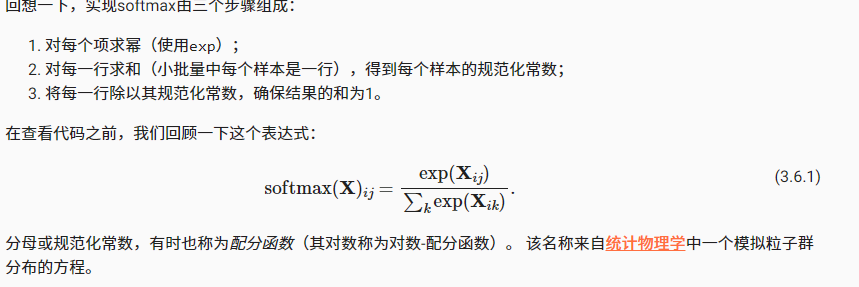

In [25]:
# 将多个类别变成了概率，从概率上来去区分类别
def softmax(X):
    X_exp = np.exp(X)
    partition = X_exp.sum(1, keepdims=True)
    return X_exp / partition  # 这里应用了广播机制

In [26]:
X = np.random.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(array([[0.0673172 , 0.1872388 , 0.23795064, 0.42808017, 0.0794132 ],
        [0.02837114, 0.0679732 , 0.09542368, 0.6241234 , 0.18410853]]),
 array([1., 1.]))

In [27]:
def net(X):
    return softmax(np.dot(X.reshape((-1, W.shape[0])), W) + b) # y = wx + b

In [44]:
y = np.array([0, 2])
y_hat = np.array([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y], y

(array([0.1, 0.5]), array([0., 2.]))

In [32]:
# 计算每个样本的交叉熵，得到每个样本的交叉熵
def cross_entropy(y_hat, y):
    return - np.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

array([2.3025851, 0.6931472])

In [49]:
# 第一步得到每一行的最大值的索引ID
# 第二步判断最大值与类别之间的是否相等，若相等，则证明其类别正确
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        print(y_hat)
        y_hat = y_hat.argmax(axis=1) # 
        print(y)
    cmp = y_hat.astype(y.dtype) == y
    return float(cmp.astype(y.dtype).sum())

In [50]:
accuracy(y_hat, y) / len(y)

[[0.1 0.3 0.6]
 [0.3 0.2 0.5]]
[0. 2.]


0.5

In [35]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    metric = Accumulator(2)  # 正确预测数、预测总数
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), d2l.size(y))
    return metric[0] / metric[1]

In [36]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)] # zip(self.data, args) 将data与args进行一一配对，产生元组列表

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [37]:
evaluate_accuracy(net, test_iter)

0.0975

In [38]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    if isinstance(updater, gluon.Trainer):
        updater = updater.step
    for X, y in train_iter:
        # 计算梯度并更新参数
        with autograd.record():
            y_hat = net(X)
            l = loss(y_hat, y)
        l.backward()
        updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.size) # 计算0 训练损失总和、1 训练准确度总和，2 总的类别数
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2] # 返回平均损失   平均准确度

In [39]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [40]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [41]:
lr = 0.1

# 参数更新，随机梯度下降算法法更新参数
def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

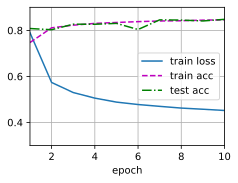

In [42]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

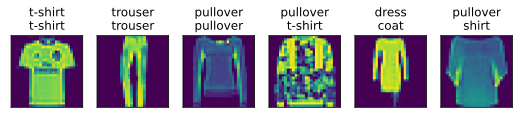

In [53]:
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)


In [57]:
print(b.shape)

(10,)


In [58]:
print(W.shape, 28*28)

(784, 10) 784
